In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#import pennylane as qml
#from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers

import matplotlib.pyplot as plt
import pandas as pd


np.random.seed(42)

In [ ]:
input = pd.read_csv("/content/output.csv")
input = input.head(500)
data = input.drop(['Timestamp','Transaction_Type','Location','Transaction_ID'], axis = 1)
y = data['Is_Fraudulent']
X  = data.drop('Is_Fraudulent',axis = 1)

# scaling the inputs is important since the embedding we use is periodic
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# scaling the labels to -1, 1 is important for the SVM and the
# definition of a hinge loss
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

In [ ]:
n_qubits = len(X_train[0])
n_qubits

5

In [ ]:
dev_kernel = qml.device("lightning.qubit", wires=n_qubits)

projector = np.zeros((2 ** n_qubits, 2 ** n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

In [ ]:
kernel(X_train[0], X_train[0])
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

In [ ]:
svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)

In [ ]:
with dev_kernel.tracker:
    predictions = svm.predict(X_test)
    accuracy_score(predictions, y_test)

In [ ]:
def circuit_evals_kernel(n_data, split):
    """Compute how many circuit evaluations one needs for kernel-based
       training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = M * M
    n_prediction = M * Mpred

    return n_training + n_prediction

In [ ]:
circuit_evals_kernel(n_data=len(X), split=len(X_train) / (len(X_train) + len(X_test)))

187500

In [ ]:
dev_var = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev_var, diff_method="parameter-shift")
def quantum_model(x, params):
    """A variational quantum model."""

    # embedding
    AngleEmbedding(x, wires=range(n_qubits))

    # trainable measurement
    StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

def quantum_model_plus_bias(x, params, bias):
    """Adding a bias."""
    return quantum_model(x, params) + bias

def hinge_loss(predictions, targets):
    """Implements the hinge loss."""
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    # trick: since the max(0,x) function is not differentiable,
    # use the mathematically equivalent relu instead
    hinge_loss = relu(hinge_loss)
    return hinge_loss

In [ ]:
def quantum_model_train(n_layers, steps, batch_size):
    """Train the quantum model defined above."""

    params = np.random.random((n_layers, n_qubits, 3))
    params_torch = torch.tensor(params, requires_grad=True)
    bias_torch = torch.tensor(0.0)

    opt = torch.optim.Adam([params_torch, bias_torch], lr=0.1)

    loss_history = []
    for i in range(steps):

        # Use .iloc to select data based on positional index
        batch_ids = np.random.choice(X_train.shape[0], batch_size, replace=False)

        X_batch = X_train[batch_ids]
        y_batch = y_train.iloc[batch_ids] # Use .iloc to access by position

        X_batch_torch = torch.tensor(X_batch, requires_grad=False)
        # Convert y_batch to a NumPy array before creating a tensor
        y_batch_torch = torch.tensor(y_batch.values, requires_grad=False)

        # ... (rest of your training loop) ...

        def closure():
            opt.zero_grad()
            preds = torch.stack(
                [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch]
            )
            loss = torch.mean(hinge_loss(preds, y_batch_torch))

            # bookkeeping
            current_loss = loss.detach().numpy().item()
            loss_history.append(current_loss)
            print("step", i, ", loss", current_loss)
            print("Layer Value : ", n_layers)
            loss.backward()
            return loss

        opt.step(closure)

    return params_torch, bias_torch, loss_history


def quantum_model_predict(X_pred, trained_params, trained_bias):
    """Predict using the quantum model defined above."""

    p = []
    for x in X_pred:

        x_torch = torch.tensor(x)
        pred_torch = quantum_model_plus_bias(x_torch, trained_params, trained_bias)
        pred = pred_torch.detach().numpy().item()
        if pred > 0:
            pred = 1
        else:
            pred = -1

        p.append(pred)
    return p

In [ ]:
n_layers = 3
batch_size = 32
steps = 200
acc = [0]
for i in range(5):
  n_layers = n_layers+1
  colorr = ['b','r','g','m','y']
  with dev_var.tracker:
      trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)
      pred_test = quantum_model_predict(X_test, trained_params, trained_bias)

  print("accuracy on test set:", accuracy_score(pred_test, y_test))
  acc.append(accuracy_score(pred_test, y_test))
  plt.plot(loss_history,label = str(n_layers), color= colorr[i-1])
  plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

NameError: name 'dev_var' is not defined

In [ ]:
n_layers = 6
batch_size = 42
steps = 200

with dev_var.tracker:
    trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)
    pred_test = quantum_model_predict(X_test, trained_params, trained_bias)

print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

In [ ]:
n_layers = 5
batch_size = 20
steps = 250

with dev_var.tracker:
    trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)
    pred_test = quantum_model_predict(X_test, trained_params, trained_bias)

print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
from sklearn.svm import SVC

# Define and train an SVM with an RBF kernel
svm_rbf = SVC(kernel="rbf", C=1.0, gamma="scale")  # You can tune C and gamma for better performance
svm_rbf.fit(X_train, y_train)

# Make predictions on the test set
pred_rbf = svm_rbf.predict(X_test)

# Evaluate accuracy
accuracy_rbf = accuracy_score(pred_rbf, y_test)
print("Accuracy on test set using SVM with RBF kernel:", accuracy_rbf)

# Visualizing the decision boundary (optional for 2D or reduced-dimensionality datasets)
# If your data is high-dimensional, consider reducing it with PCA or TSNE for visualization purposes


Accuracy on test set using SVM with RBF kernel: 0.952


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [ 1],
    'gamma': [ 0.1],
}

# Perform grid search
grid_search = GridSearchCV(SVC(kernel="rbf"), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best parameters and their performance
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Test the best model
best_model = grid_search.best_estimator_
pred_best_rbf = best_model.predict(X_test)
svm_train_pred = best_model.predict(X_train)
accuracy_best_rbf = accuracy_score(pred_best_rbf, y_test)
print("Accuracy on test set with best RBF SVM:", accuracy_best_rbf)


Best parameters found: {'C': 1, 'gamma': 0.1}
Best cross-validation score: 0.9466666666666667
Accuracy on test set with best RBF SVM: 0.952


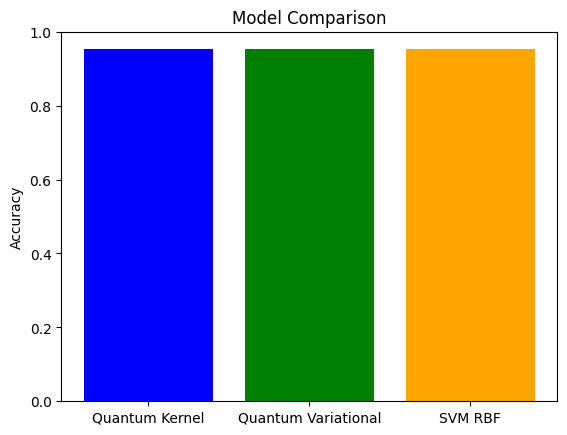

In [ ]:
# Collect accuracies
model_names = ["Quantum Kernel", "Quantum Variational", "SVM RBF"]
accuracies = [
    accuracy_score(predictions, y_test),  # Quantum Kernel
    accuracy_score(pred_test, y_test),   # Quantum Variational
    accuracy_rbf,                        # SVM RBF
]

# Plot
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange'])
plt.ylim((0, 1))
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()


Step 0: Loss = 0.3508106127474789
Step 10: Loss = 0.4155963816972608
Step 20: Loss = 0.4215619460970161
Step 30: Loss = 0.4171948851226075
Step 40: Loss = 0.35125007745607645
Step 50: Loss = 0.38059956183132027
Step 60: Loss = 0.38673175538617016
Step 70: Loss = 0.5193855509111412
Step 80: Loss = 0.42213975861408837
Step 90: Loss = 0.32266002628721535
Step 100: Loss = 0.3462689769157335
Step 110: Loss = 0.37650584760252787
Step 120: Loss = 0.40955832382178764
Step 130: Loss = 0.3466171261670275
Step 140: Loss = 0.3916769018589806
Step 150: Loss = 0.423831357534259
Step 160: Loss = 0.34637904450864787
Step 170: Loss = 0.35943776044057796
Step 180: Loss = 0.3651209293156188
Step 190: Loss = 0.35899635330005425
Step 200: Loss = 0.3312126398093479
Step 210: Loss = 0.33424250835280883
Step 220: Loss = 0.3901760048205585
Step 230: Loss = 0.3623871875197475
Step 240: Loss = 0.3335849046612006


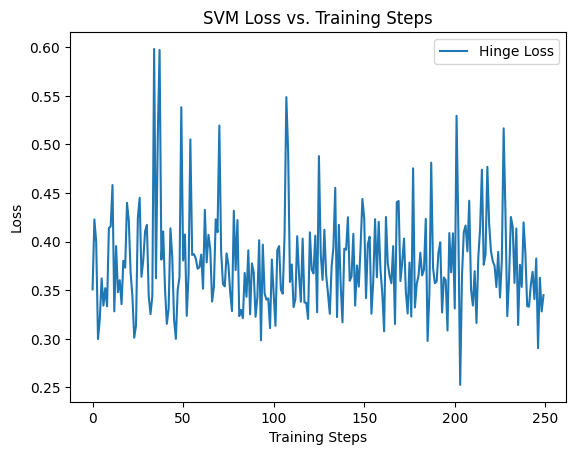

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import hinge_loss

# Initialize the SGDClassifier with hinge loss (SVM-like behavior)
sgd_clf = SGDClassifier(
    loss="hinge",  # Hinge loss for SVM
    max_iter=1,    # One iteration per partial_fit
    warm_start=True,  # Continue training without reinitializing
    learning_rate="constant",
    eta0=1,     # Initial learning rate
    random_state=42
)

# Variables to store loss and steps
loss_history = []
n_steps = 250

# Train for multiple steps
for step in range(n_steps):
    sgd_clf.partial_fit(X_train, y_train, classes=np.unique(y_train))  # Perform one step of training
    y_pred_train = sgd_clf.decision_function(X_train)  # Predicted decision scores
    loss = hinge_loss(y_train, y_pred_train)  # Compute hinge loss
    loss_history.append(loss)

    # Print progress every 50 steps
    if step % 10 == 0:
        print(f"Step {step}: Loss = {loss}")

# Plot loss vs. steps
plt.plot(range(n_steps), loss_history, label="Hinge Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("SVM Loss vs. Training Steps")
plt.legend()
plt.show()


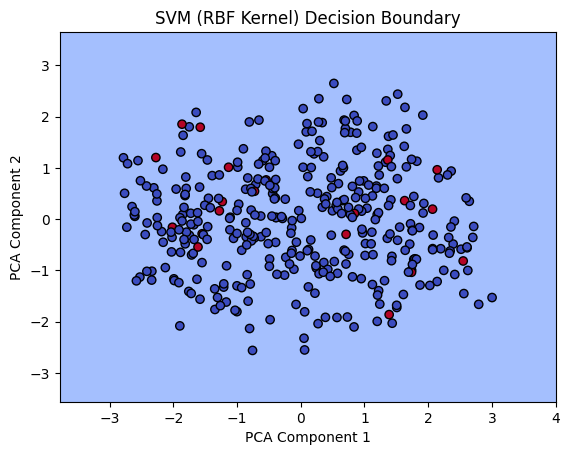

In [ ]:
from sklearn.decomposition import PCA

# Reduce feature space to 2D for visualization
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

# Train the SVM with RBF kernel on the 2D data
svm_rbf_2d = SVC(kernel="rbf", C=1.0, gamma="scale")
svm_rbf_2d.fit(X_train_2d, y_train)

# Generate a meshgrid for plotting the decision boundary
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Predict decision boundary
Z = svm_rbf_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolor="k")
plt.title("SVM (RBF Kernel) Decision Boundary")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


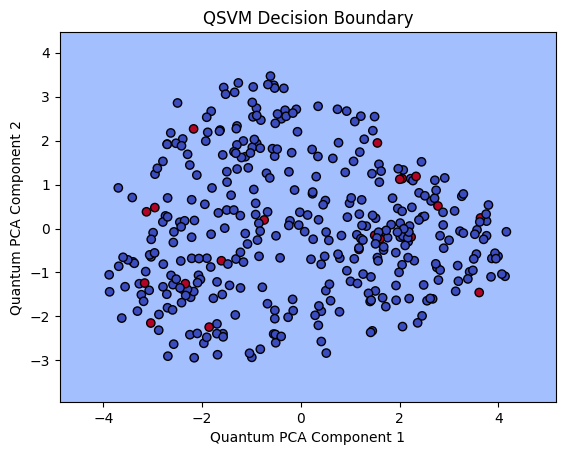

In [ ]:
# Compute the quantum kernel matrix for training data
kernel_train_matrix = kernel_matrix(X_train, X_train)

# Apply PCA to reduce the kernel space to 2D
pca_qsvm = PCA(n_components=2)
X_train_qsvm_2d = pca_qsvm.fit_transform(kernel_train_matrix)

# Train the classical SVM in the reduced quantum kernel space
svm_qsvm_2d = SVC(kernel="linear")
svm_qsvm_2d.fit(X_train_qsvm_2d, y_train)

# Generate a meshgrid for plotting the decision boundary
x_min, x_max = X_train_qsvm_2d[:, 0].min() - 1, X_train_qsvm_2d[:, 0].max() + 1
y_min, y_max = X_train_qsvm_2d[:, 1].min() - 1, X_train_qsvm_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Predict decision boundary
Z = svm_qsvm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train_qsvm_2d[:, 0], X_train_qsvm_2d[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolor="k")
plt.title("QSVM Decision Boundary")
plt.xlabel("Quantum PCA Component 1")
plt.ylabel("Quantum PCA Component 2")
plt.show()


ValueError: X has 5 features, but SVC is expecting 3 features as input.

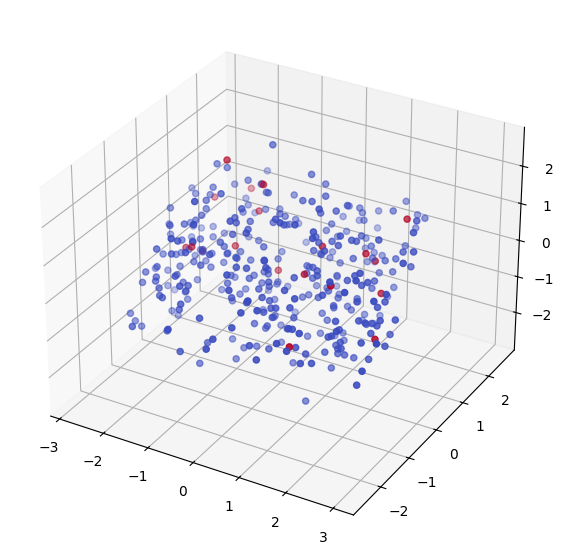

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce feature space to 3D for visualization
pca_3d = PCA(n_components=3)
X_train_3d = pca_3d.fit_transform(X_train)
X_test_3d = pca_3d.transform(X_test)

# Train SVM with RBF kernel on the 3D data
svm_rbf_3d = SVC(kernel="rbf", C=1.0, gamma="scale")
svm_rbf_3d.fit(X_train_3d, y_train)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of data points
sc = ax.scatter(X_train_3d[:, 0], X_train_3d[:, 1], X_train_3d[:, 2], c=y_train, cmap=plt.cm.coolwarm, s=20)

# Create a grid for decision surface
x_min, x_max = X_train_3d[:, 0].min() - 1, X_train_3d[:, 0].max() + 1
y_min, y_max = X_train_3d[:, 1].min() - 1, X_train_3d[:, 1].max() + 1
z_min, z_max = X_train_3d[:, 2].min() - 1, X_train_3d[:, 2].max() + 1
xx, yy, zz = np.meshgrid(
    np.linspace(x_min, x_max, 30),
    np.linspace(y_min, y_max, 30),
    np.linspace(z_min, z_max, 30)
)

# Evaluate the decision function on the grid
grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
decision_function = svm_rbf_3d.decision_function(pca_3d.inverse_transform(grid))
decision_function = decision_function.reshape(xx.shape)

# Plot the decision boundary
ax.contourf(xx, yy, zz, decision_function, levels=1, alpha=0.5, cmap=plt.cm.coolwarm)

# Customize plot
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
plt.title("SVM (RBF Kernel) in 3D")
plt.show()


TypeError: Input z must be 2D, not 3D

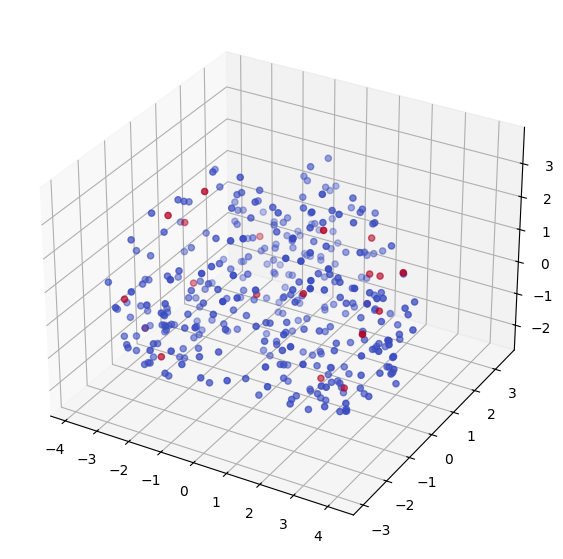

In [ ]:
# Compute the quantum kernel matrix
kernel_train_matrix = kernel_matrix(X_train, X_train)

# Apply PCA to reduce the quantum kernel space to 3D
pca_qsvm_3d = PCA(n_components=3)
X_train_qsvm_3d = pca_qsvm_3d.fit_transform(kernel_train_matrix)

# Train a classical SVM in the reduced quantum kernel space
svm_qsvm_3d = SVC(kernel="linear")
svm_qsvm_3d.fit(X_train_qsvm_3d, y_train)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of data points
sc = ax.scatter(
    X_train_qsvm_3d[:, 0], X_train_qsvm_3d[:, 1], X_train_qsvm_3d[:, 2],
    c=y_train, cmap=plt.cm.coolwarm, s=20
)

# Create a grid for decision surface
x_min, x_max = X_train_qsvm_3d[:, 0].min() - 1, X_train_qsvm_3d[:, 0].max() + 1
y_min, y_max = X_train_qsvm_3d[:, 1].min() - 1, X_train_qsvm_3d[:, 1].max() + 1
z_min, z_max = X_train_qsvm_3d[:, 2].min() - 1, X_train_qsvm_3d[:, 2].max() + 1
xx, yy, zz = np.meshgrid(
    np.linspace(x_min, x_max, 30),
    np.linspace(y_min, y_max, 30),
    np.linspace(z_min, z_max, 30)
)

# Evaluate the decision function on the grid
grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
decision_function = svm_qsvm_3d.decision_function(grid)
decision_function = decision_function.reshape(xx.shape)

# Plot the decision boundary
ax.contourf(xx, yy, zz, decision_function, levels=1, alpha=0.5, cmap=plt.cm.coolwarm)

# Customize plot
ax.set_xlabel("Quantum PCA Component 1")
ax.set_ylabel("Quantum PCA Component 2")
ax.set_zlabel("Quantum PCA Component 3")
plt.title("QSVM in 3D")
plt.show()


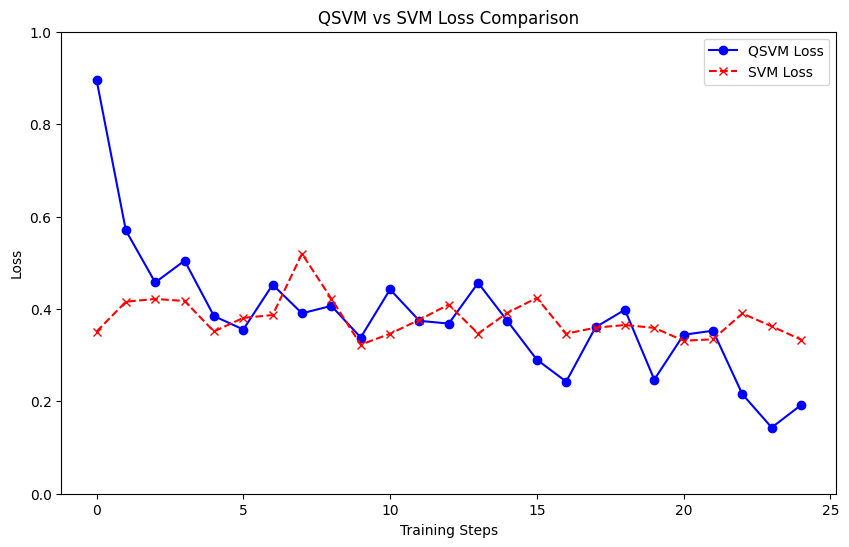

In [ ]:
import matplotlib.pyplot as plt

# === Provided QSVM Loss Data ===
loss_history_qsvm = [
    0.8964256657938676, 0.5698557302355767, 0.45725014358758925, 0.5044769518077373, 0.38466224670410154,
    0.3554268479347229, 0.4524340763688087, 0.39048034846782687, 0.40662714689970014, 0.33813886195421217,
    0.4422280639410019, 0.3742225870490074, 0.3682917393743992, 0.45635356903076174, 0.37357175946235655,
    0.2901430070400238, 0.24268466085195542, 0.36042899936437606, 0.398202209174633, 0.24700614288449288,
    0.3440428085625172, 0.3528846174478531, 0.21544495671987535, 0.14327943921089173, 0.19190777689218522
]

# === Provided SVM Loss Data ===
loss_history_svm = [
    0.3508106127474789, 0.4155963816972608, 0.4215619460970161, 0.4171948851226075, 0.35125007745607645,
    0.38059956183132027, 0.38673175538617016, 0.5193855509111412, 0.42213975861408837, 0.32266002628721535,
    0.3462689769157335, 0.37650584760252787, 0.40955832382178764, 0.3466171261670275, 0.3916769018589806,
    0.423831357534259, 0.34637904450864787, 0.35943776044057796, 0.3651209293156188, 0.35899635330005425,
    0.3312126398093479, 0.33424250835280883, 0.3901760048205585, 0.3623871875197475, 0.3335849046612006
]

# === Plot Loss vs. Steps for Both Models ===
plt.figure(figsize=(10, 6))

# Plot for QSVM loss
plt.plot(range(len(loss_history_qsvm)), loss_history_qsvm, label="QSVM Loss", color='blue', linestyle='-', marker='o')

# Plot for SVM loss
plt.plot(range(len(loss_history_svm)), loss_history_svm, label="SVM Loss", color='red', linestyle='--', marker='x')

plt.title("QSVM vs SVM Loss Comparison")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.ylim((0, 1))
plt.legend()
plt.show()


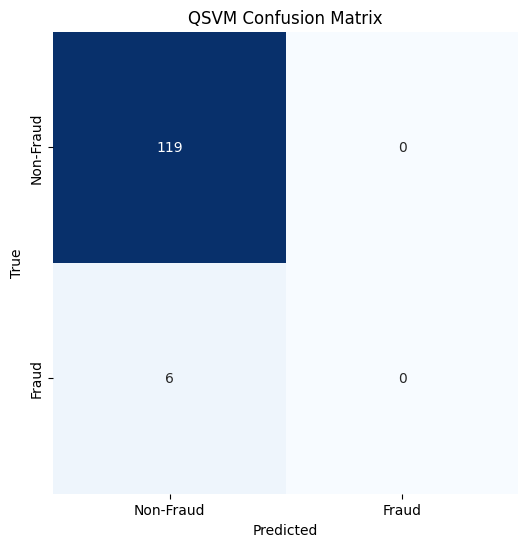

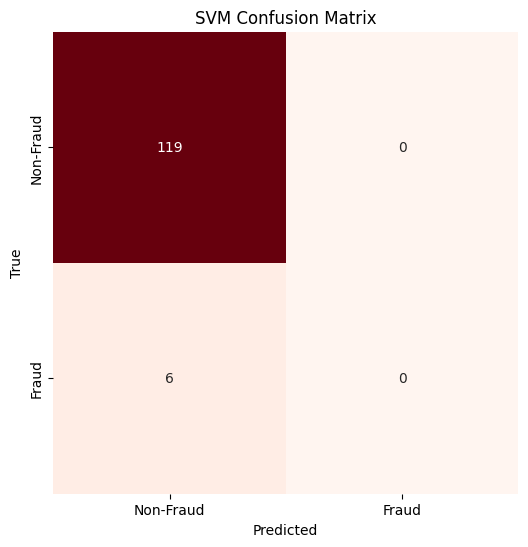

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_qsvm = confusion_matrix(y_test, pred_test)
cm_svm = confusion_matrix(y_test, pred_best_rbf)

# Plot for QSVM
plt.figure(figsize=(6, 6))
sns.heatmap(cm_qsvm, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("QSVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot for SVM
plt.figure(figsize=(6, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap="Reds", cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


step 0 , loss 1.0294439611025155
step 10 , loss 0.6924970418214798
step 20 , loss 0.6903619974851608
step 30 , loss 0.5920701749622822
step 40 , loss 0.4724544003605843
step 50 , loss 0.26951357424259187
step 60 , loss 0.4513962745666504
step 70 , loss 0.16409644484519958
step 80 , loss 0.15316762328147887
step 90 , loss 0.250090503692627
step 100 , loss 0.1168931782245636
step 110 , loss 0.14727558195590973
step 120 , loss 0.23051653504371644
step 130 , loss 0.20456768572330475
step 140 , loss 0.37514039874076843
step 150 , loss 0.2826800137758255
step 160 , loss 0.1285207062959671
step 170 , loss 0.1264891505241394
step 180 , loss 0.13950518965721131
step 190 , loss 0.2824602842330933
step 200 , loss 0.12018299698829651
step 210 , loss 0.12657971680164337
step 220 , loss 0.19329380989074707
step 230 , loss 0.20399651825428008
step 240 , loss 0.33197611272335054
QSVM Training Time: 2842.343626499176 seconds
SVM Training Time: 0.0051157474517822266 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


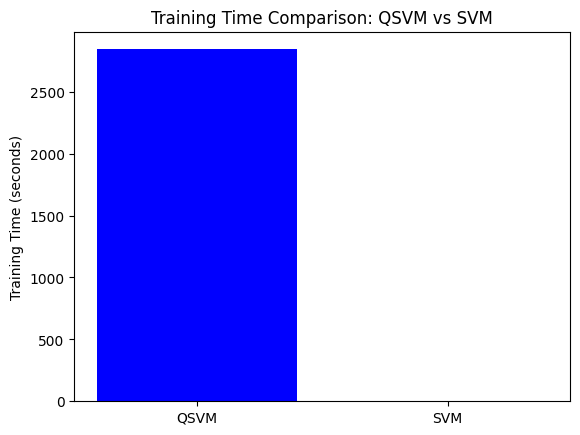

In [ ]:
import time

start_qsvm = time.time()
trained_params, trained_bias, loss_history_qsvm = quantum_model_train(n_layers, steps, batch_size)
end_qsvm = time.time()
qsvm_train_time = end_qsvm - start_qsvm

start_svm = time.time()
sgd_clf.fit(X_train, y_train)
end_svm = time.time()
svm_train_time = end_svm - start_svm

print(f"QSVM Training Time: {qsvm_train_time} seconds")
print(f"SVM Training Time: {svm_train_time} seconds")

# Plot comparison
plt.bar(['QSVM', 'SVM'], [qsvm_train_time, svm_train_time], color=['blue', 'red'])
plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison: QSVM vs SVM")
plt.show()


QSVM Accuracy: 0.952
SVM Accuracy: 0.952


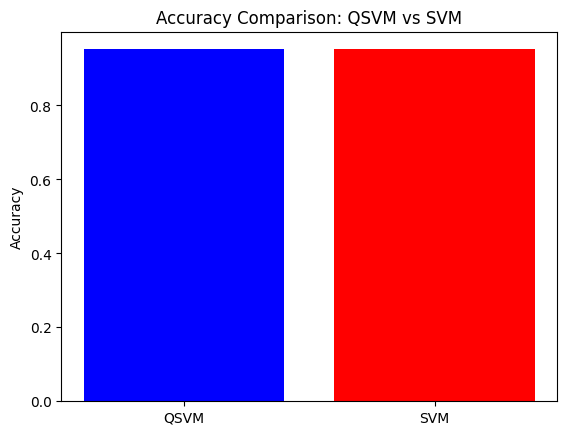

In [ ]:
# Accuracy comparison
accuracy_qsvm = accuracy_score(pred_test, y_test)
accuracy_svm = accuracy_score(pred_best_rbf, y_test)

print(f"QSVM Accuracy: {accuracy_qsvm}")
print(f"SVM Accuracy: {accuracy_svm}")

plt.bar(['QSVM', 'SVM'], [accuracy_qsvm, accuracy_svm], color=['blue', 'red'])
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: QSVM vs SVM")
plt.show()


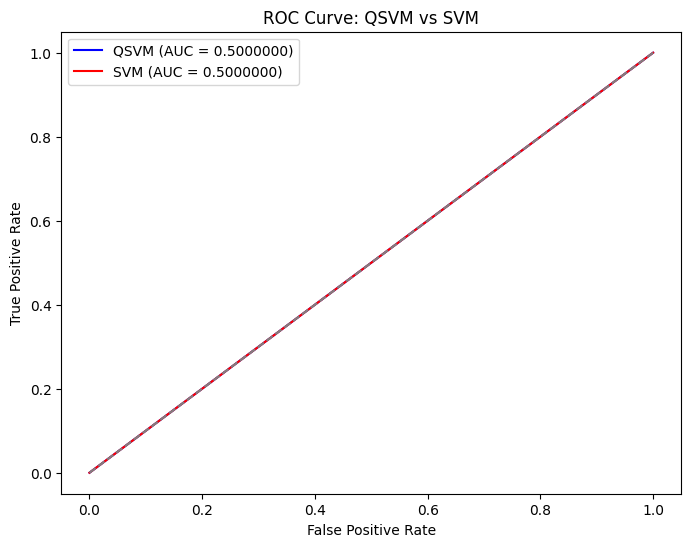

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr_qsvm, tpr_qsvm, _ = roc_curve(y_test, pred_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test, pred_best_rbf)

auc_qsvm = auc(fpr_qsvm, tpr_qsvm)
auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_qsvm, tpr_qsvm, color='blue', label=f'QSVM (AUC = {auc_qsvm:.7f})')
plt.plot(fpr_svm, tpr_svm, color='red', label=f'SVM (AUC = {auc_svm:.7f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: QSVM vs SVM')
plt.legend()
plt.show()


QSVM Parameters: 75
SVM Non-Zero Coefficients: 5
SVM Support Vectors: 82


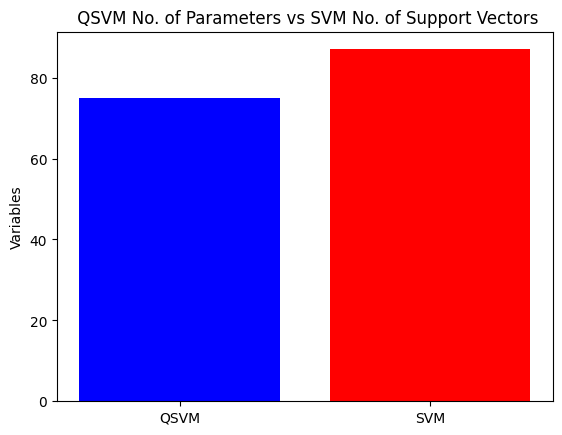

In [ ]:
# For QSVM, we already have the number of parameters in the quantum model
num_params_qsvm = trained_params.numel()  # Number of trainable parameters in QSVM

# For SVM (using SGDClassifier), we can estimate the number of non-zero coefficients as a proxy for model complexity
non_zero_coeffs_svm = np.sum(sgd_clf.coef_ != 0)  # Non-zero coefficients for linear SVM

# For SVM (using SVC), we can also get the number of support vectors
svc_clf = SVC(kernel='rbf', random_state=42)
svc_clf.fit(X_train, y_train)
num_support_vectors_svm = len(svc_clf.support_vectors_)  # Number of support vectors in SVM


# Print out the complexities for comparison
print(f"QSVM Parameters: {num_params_qsvm}")
print(f"SVM Non-Zero Coefficients: {non_zero_coeffs_svm}")
print(f"SVM Support Vectors: {num_support_vectors_svm}")

# Plot model complexity comparison
plt.bar(['QSVM', 'SVM'], [num_params_qsvm, num_support_vectors_svm + non_zero_coeffs_svm], color=['blue', 'red'])
plt.ylabel("Variables")
plt.title(" QSVM No. of Parameters vs SVM No. of Support Vectors")
plt.show()


# ***All in PennyLane*** Till Now

#*** Starting Qiskit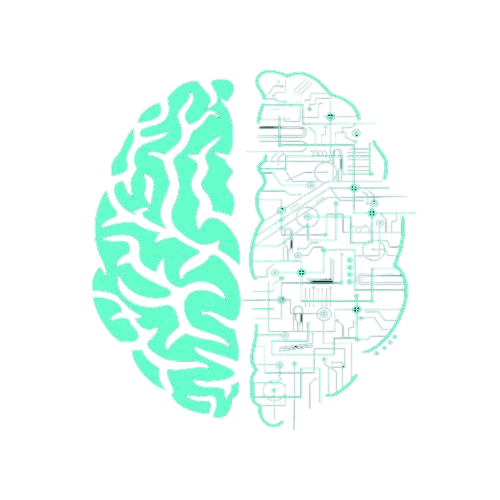***

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt

In [ ]:
input = pd.read_csv('/content/output.csv')
input2 = input.head(500)

In [ ]:
data = input2.drop(['Timestamp','Transaction_Type','Location','Transaction_ID'], axis = 1)
y = data['Is_Fraudulent']
x  = data.drop('Is_Fraudulent',axis = 1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


In [ ]:
# number of qubits is equal to the number of features
num_qubits = 5

# number of steps performed during the training procedure
tau = 100

# regularization parameter
C = 1000

In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Initialize your account
!pip install qiskit_ibm_runtime
from qiskit_ibm_runtime import QiskitRuntimeService


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.27.1
    Uninstalling pydantic_core-2.27.1:
      Successfully uninstalled pydantic_core-2.27.1
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.10.3
    Uninstalling pydantic-2.10.3:
      Successfully uninstalled pydantic-2.10.3


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
# Save your account to disk.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="d2e0ed6f808a4abe7851b12b9e69c1f24cc2c5d25244c624047e4a1ca7637d7dfe4af4b8dc7d631298e7466002732d3d8bd93a0967807ff1a14c19790efa7a24")

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_machine_learning.state_fidelities import ComputeUncompute
# Initialize account.
service = QiskitRuntimeService()

In [ ]:
with Session(service=service) as session:  # Choose your desired backend
    sampler = Sampler(session=session)
    fidelity = ComputeUncompute(sampler=sampler) # Pass the sampler instance

qkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

print(feature_map.decompose())

TypeError: Session.__init__() got an unexpected keyword argument 'service'

In [ ]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.kernels import FidelityQuantumKernel

algorithm_globals.random_seed = 42

feature_map = ZZFeatureMap(feature_dimension=5, reps=1, entanglement="full")
fidelity = ComputeUncompute(sampler=service)

qkernel = FidelityQuantumKernel(fidelity = fidelity, feature_map=feature_map)

print(feature_map.decompose())

ValueError: The sampler should be an instance of BaseSampler or BaseSamplerV2, but got <class 'qiskit_ibm_runtime.qiskit_runtime_service.QiskitRuntimeService'>

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.optimizers import SPSA
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC

from qiskit_machine_learning.datasets import ad_hoc_data
import sklearn.metrics as metrics

# Use QSVC for classification
qsvc = QSVC(quantum_kernel=qkernel)

# Fit the QSVC
qsvc.fit(X_train, y_train)

# Predict the labels
labels_test = qsvc.predict(X_test)

# Evalaute the test accuracy
accuracy_test = metrics.accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

AttributeError: 'QiskitRuntimeService' object has no attribute 'run'

QSVM Pennylane: 0.952
QSVM Qiskit: 0.952


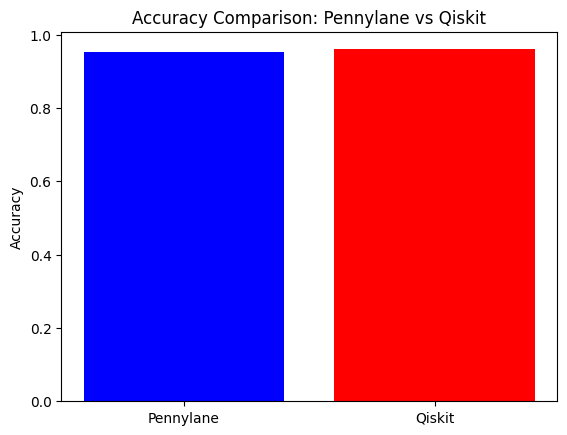

In [ ]:
# Accuracy comparison

print(f"QSVM Pennylane: {accuracy_qsvm}")
print(f"QSVM Qiskit: {accuracy_svm}")

plt.bar(['Pennylane', 'Qiskit'], [accuracy_qsvm, accuracy_test], color=['blue', 'red'])
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Pennylane vs Qiskit")
plt.show()